In [1]:
import os as os

import numpy as np

import pandas as pd
from bigdatavqa.coreset import Coreset
from bigdatavqa.k3meansclustering import K3MeansClusteringVQE, K3MeansClusteringRandom
from bigdatavqa.vqe_utils import get_VQE_circuit, get_K3_Hamiltonian
from bigdatavqa.optimizer import get_optimizer_for_VQE
import cudaq
import matplotlib.pyplot as plt

In [2]:
qubits = 10
coreset_size = int(qubits / 2)
circuit_depth = 1
max_shots = 1000
max_iterations = 100
number_of_experiment_runs = 5
number_of_corsets_to_evaluate = 15
number_of_centroid_evaluation = 20

In [3]:
raw_data = Coreset.create_dataset(1000)

coreset = Coreset(
    raw_data=raw_data,
    number_of_sampling_for_centroids=10,
    coreset_size=10,
    number_of_coresets_to_evaluate=4,
    coreset_method="BFL2",
)

coreset_vectors, coreset_weights = coreset.get_best_coresets()

coreset_df = pd.DataFrame(coreset_vectors, columns=list("XY"))
coreset_df["weights"] = coreset_weights
coreset_df["Name"] = [chr(i + 65) for i in coreset_df.index]

Using BFL2 method to generate coresets


/home/yogi/.pyenv/versions/3.10.0/envs/VQA/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/yogi/.pyenv/versions/3.10.0/envs/VQA/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/yogi/.pyenv/versions/3.10.0/envs/VQA/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/yogi/.pyenv/versions/3.10.0/envs/VQA/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `

In [4]:
optimizer = cudaq.optimizers.COBYLA()

k3meansVQE = K3MeansClusteringVQE(
        create_circuit=get_VQE_circuit,
        circuit_depth=1,
        optimizer_function=get_optimizer_for_VQE,
        optimizer=optimizer,
        create_Hamiltonian=get_K3_Hamiltonian,
        number_of_qubits_representing_data=2,
        normalize_vectors=True,
        max_iterations=max_iterations,
        max_shots=max_shots,
    )

centers = k3meansVQE.get_cluster_centers(
    coreset_df=coreset_df, vector_columns=["X", "Y"], weight_columns="weights"
)


VQE_cost_value = k3meansVQE.get_3means_cost(
    raw_data, centers
)


print(f"VQE cost value: {VQE_cost_value}")

RuntimeError: NLOpt runtime error: nlopt failure

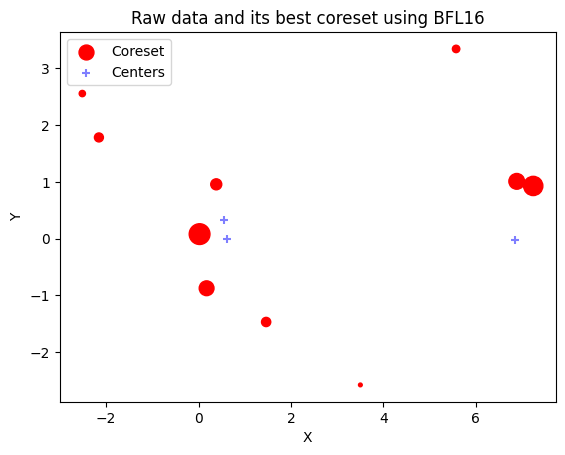

In [ ]:
df = pd.DataFrame(
        {"X": coreset_vectors[:, 0], "Y": coreset_vectors[:, 1], "Weights": coreset_weights}
    )
plt.scatter(df["X"], df["Y"], s=df["Weights"], label="Coreset", color="r")
plt.scatter(centers[:, 0], centers[:, 1], label="Centers", alpha=0.5, color="b", marker="+")
plt.xlabel("X")
plt.ylabel("Y")
plt.title("Raw data and its best coreset using BFL16")
plt.legend()
plt.show()

## Random clustering

In [ ]:
K3MeansRandom = K3MeansClusteringRandom()
centers = K3MeansRandom.get_cluster_centers(
    coreset_df=coreset_df, vector_columns=["X", "Y"], weight_columns="weights"
)

Random_cost = K3MeansRandom.get_3means_cost(raw_data, centers)


# Analyzing results

In [ ]:
# Define the cost values
cost_values = [random_cluster_cost_value, VQE_cost_value, kmeans_cost_value, brute_force_cost_value]

# Define the labels for the x-axis
labels = ['Random Cluster','VQE', 'K-means', 'Brute Force']

# Create the bar chart
plt.bar(labels, cost_values)

# Add labels and title
plt.xlabel('Method')
plt.ylabel('Cost Value')
plt.title('Cost Values Comparison (Lower is better)')

# Display the chart
plt.show()